In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path

# import custom functions from src folder
module_path = str(Path.cwd() / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from robot import Robot

### The robot
Inside the box there is a two-joint robot-arm which draws points on a surface. The screen shows the position of the point the robot arm reached. The position the robot reaches is decided by the parameters $r_1$, $r_2$, $\theta_1$ and $\theta_2$, indicating the length of the first and second rod and the angle of the joints.


$(\theta_1, \theta_2, r_1, r_2) \rightarrow (x_1, x_2) = (r_1 \cos(\theta_1) + r_2 \cos(\theta_1 + \theta_2), r_1 \sin(\theta_1) + r_2 \sin(\theta_1 + \theta_2))$

<p align="center">
  <img src="../fig/toy_experiment_robot_arm.png" height="350">
</p>

The robot maker has made the machine non-deterministic by letting three of the four parameters be drawn from fixed distributions according to the color. Internally, the algorithm first decides the color (or a color button is pressed), then $\theta_1, \theta_2$ and $r_1$ are randomly sampled from their distributions. The first joint can rotate 360 degrees, while the second joint can rotate only 180 degrees as indicated in the figure. $\theta_1$ and $\theta_2$ are chosen completely randomly within these constraints. The length of the first arm, $r_1$, is set by an extending mechanism according to the chosen color $c$. The extending mechanism is not very precise and only approximately hits the programmed length $R_{c}$. The actually reached length is modelled by a gamma function with mean at $\mu_{r1, c} = k_{c} s = R_{c}$. When the 'simulation' button is pressed, the colors are first drawn from a discrete distribution.


Distributed features:

$
\begin{aligned}
& C \in\left\{\text { "red" } \text { "green" }\right\} \\
& \theta_1 \in[0,2 \pi) \subseteq \mathbb{R}^1 \\
& \theta_2 \in[0, \pi) \subseteq \mathbb{R}^1 \\
& \vec{x}=\left(x_1, x_2\right) \in X \subseteq \mathbb{R}^2 \\
& r_1 \in\left(2 r_2, \infty\right) \subseteq \mathbb{R}^1
\end{aligned}
$

Known distributions:

$
\begin{aligned}
& P(c)= \begin{cases}0.5, & c=\text { "red" } \\
0.5, & c=\text { "green" }\end{cases} \\
& p\left(\theta_1\right)=1 / 2 \pi \\
& p\left(\theta_2\right)=1 / \pi
\end{aligned}
$

$
p\left(r_1 \mid c\right)=\frac{\left(r_1-2 r_2\right)^{k_c-1} e^{-z / c}}{s^{k_c} \Gamma\left(k_c\right)}
$

$
\begin{aligned}
& k_c= \begin{cases}5, & c=\text { "red" } \\
3, & c=\text { "green" }\end{cases} \\
\end{aligned}
$

$s=$ constant

Functional dependence:

$
\begin{aligned}
& \vec{x}=\vec{g}\left(\theta_1, \theta_2, r_1\right)=\left(g_1, g_2\right)=\left(x_1, x_2\right) \\
& g_1=r_1 \cos \theta_1+r_2 \cos \left(\theta_1+\theta_2\right) \\
& g_2=r_1 \sin \theta_1+r_2 \sin \left(\theta_1+\theta_2\right)
\end{aligned}
$

### But wait, you said this was a real problem and now it's all math?
This is as good as it is every going to get with calculus. Math is the only established way we have of attacking a physical problem like the one in this problem.

In [2]:
def robot_arm(theta1, theta2, r1, r2):
    ya = r1*np.cos(theta1) + r2*np.cos(theta1 + theta2)
    yb = r1*np.sin(theta1) + r2*np.sin(theta1 + theta2)
    return ya, yb

In [3]:
robot_arm(0, 0, 3, 1)

(4.0, 0.0)

In [4]:
# CONSTANTS
R_2 = 2
k_red = 5
k_green = 3
scale = 2
rng = np.random.default_rng()
def sample_a1(c, n): return(np.array([random.uniform(0, 2*np.pi) for i in range(n)]))
def sample_a2(c, n): return(np.array([random.uniform(0, 2*np.pi) for i in range(n)]))
def sample_r1(c, n):
    r1_arr = np.zeros(n)
    r1_arr = np.where(c=="red", 2*R_2 + rng.gamma(k_red, scale, n), r1_arr)
    r1_arr = np.where(c=="green", 2*R_2 + rng.gamma(k_green, scale, n), r1_arr)
    return r1_arr
def sample_c(n): return(rng.choice(["red", "green"], n))

Text(0, 0.5, 'x2')

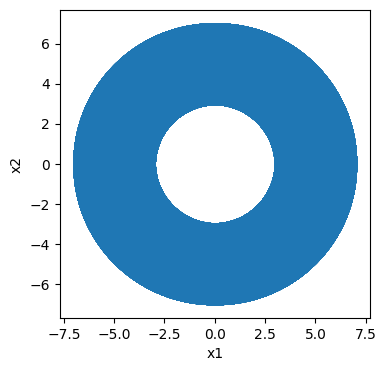

In [5]:
# Look at the mapping function for constant R
nx = 2000
#angles
a1 = np.linspace(-np.pi, np.pi, nx)
a2 = np.linspace(0, np.pi, nx)

aa1, aa2 = np.meshgrid(a1, a2)

xx1, xx2 = robot_arm(aa1, aa2, 5, R_2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4))

ax.scatter(xx1, xx2, s=1, alpha=0.1)
ax.set_xlabel("x1")
ax.set_ylabel("x2")

Text(0, 0.5, 'x1')

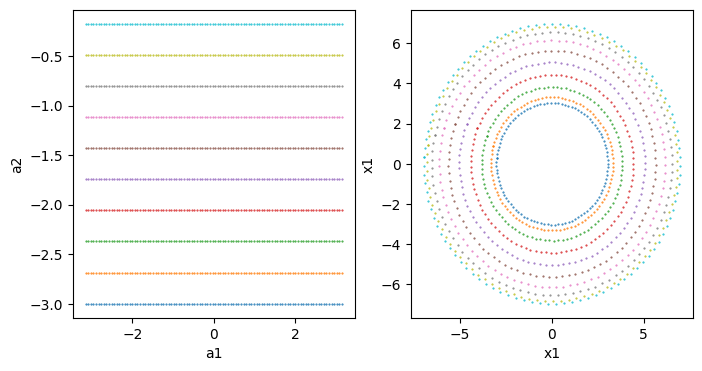

In [6]:
# Look at the mapping function for constant theta2
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a1 = np.linspace(-np.pi, np.pi, na)
for i in range(lines):
    da2 = np.pi/lines
    a2 = 0*a1 -3 + i*da2
    x1, x2 = robot_arm(a1, a2, 5, R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

Text(0, 0.5, 'x1')

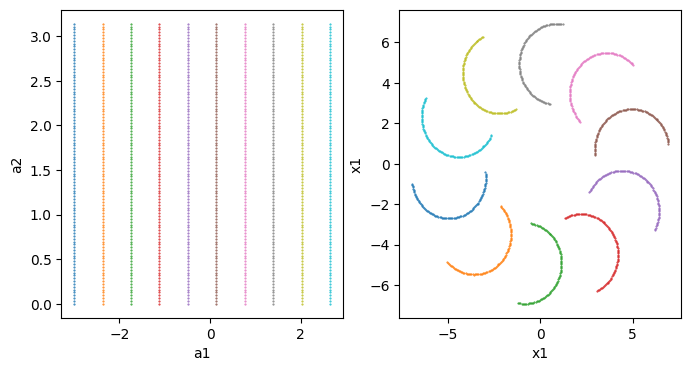

In [7]:
# Look at the mapping function for constant theta1
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a2 = np.linspace(0, np.pi, na)
for i in range(lines):
    da1 = 2*np.pi/lines
    a1 = 0*a2 -3 + i*da1
    x1, x2 = robot_arm(a1, a2, 5, R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

In [8]:
# Custom plot function
def plot_data(df):

    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 6))

    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=ax[0][0])
    sn.histplot(df_red[["x1", "x2"]], palette=["#ffae9d", "#a82b11"], alpha=0.5, ax=ax[0][1], element="step")
    
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="green", alpha=0.1, ax=ax[1][0])
    sn.histplot(df_green[["x1", "x2"]], palette=["#c3e6c5", "#0b8e14"], alpha=0.5, ax=ax[1][1], element="step")
    
    ax[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    ax[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot r1
    sn.histplot(df_red, x="r1", color="red", ax=ax[0][2])
    sn.histplot(df_green, x="r1", color="green", ax=ax[1][2])
    sn.lineplot(x=[2*R_2 + k_red*scale]*2, y=[0, 350], estimator=None, lw=2, alpha=1, c="black", ax=ax[0][2], label="Expected mean")
    sn.lineplot(x=[2*R_2 + k_green*scale]*2, y=[0, 350], estimator=None, lw=2, alpha=1, c="black", ax=ax[1][2], label="Expected mean")
    ax[0][2].set_xlim(R_2, max(df["r1"]))
    ax[1][2].set_xlim(R_2, max(df["r1"]))

    return fig, ax



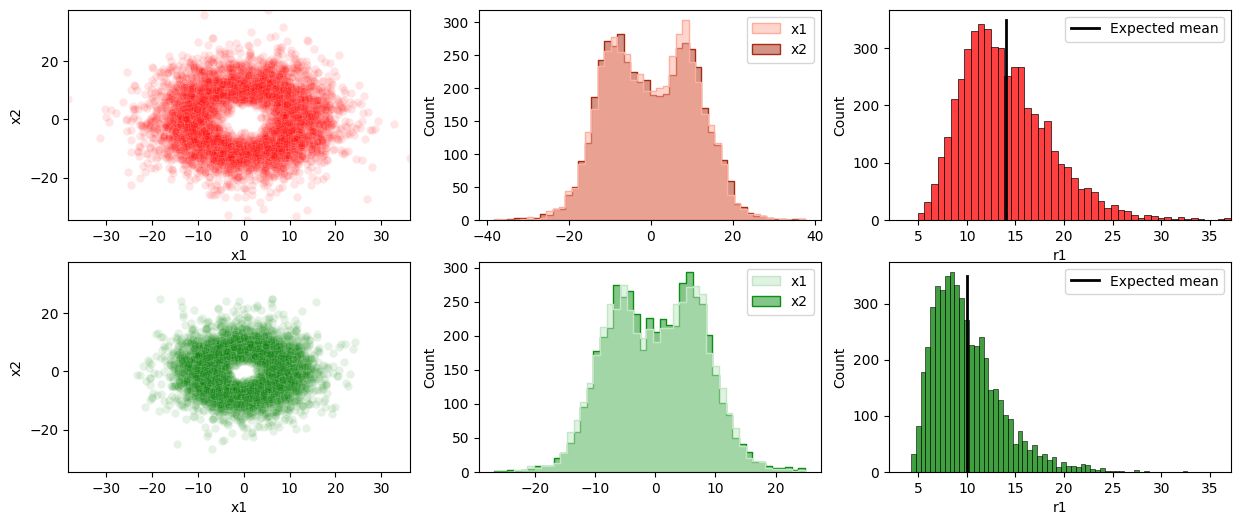

In [9]:
myRobot = Robot(seed=24)
df_many = myRobot.simulate(10000, black_box=False)
fig, ax = plot_data(df_many)

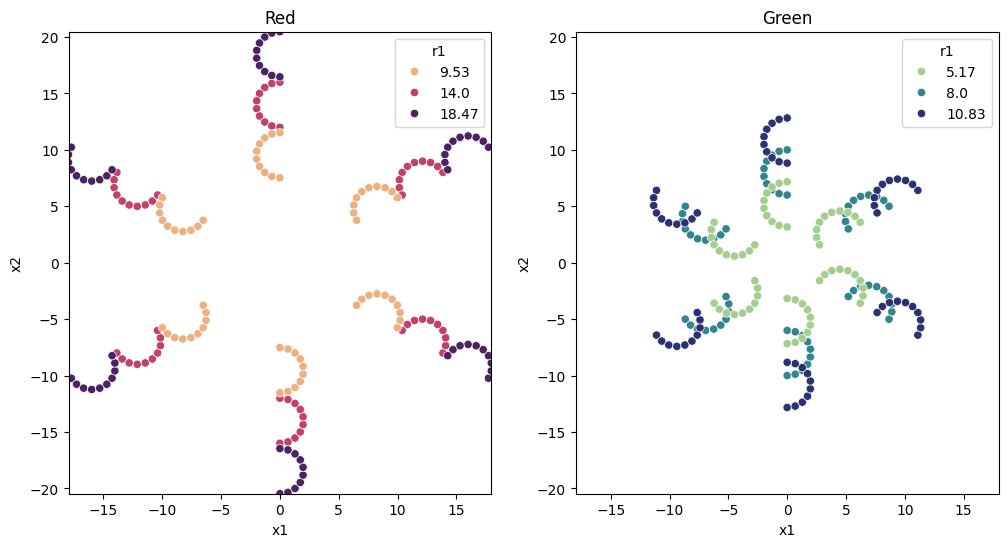

In [11]:
def plot_testdata(df):

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", hue="r1", c="red", alpha=1, ax=ax[0], palette="flare")
    
    
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", hue="r1", c="green", alpha=1, ax=ax[1], palette="crest")
    
    ax[0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[0].set_ylim(min(df["x2"]), max(df["x2"]))
    ax[0].set_title("Red")

    ax[1].set_ylim(min(df["x2"]), max(df["x2"]))
    ax[1].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[1].set_title("Green")

    return fig, ax

df_test = myRobot.gen_testdata(10, 6, black_box=False)
fig, ax = plot_testdata(df_test)

df_test = myRobot.gen_testdata(10, 6, black_box=False)

In [12]:
df_test.to_csv("data/test.csv", index=False)